In [9]:
import sys
import os
# Add the parent directory
# Removed old path hack; using package imports))

from llm_prior_project.models.expert_ridge import ExpertRidge
from llm_prior_project.models.custom_ridge import CustomRidge
from llm_prior_project.priors.target_elicitor import LLMTargetElicitor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge as SklearnRidge

In [30]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge as SklearnRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Load California housing dataset
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

# Use smaller subset for testing
X_small = X.head(2000)
y_small = y.head(2000)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42
)

print("Data Setup Complete")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features: {list(X_train.columns)}")
print(f"Target range: {y_train.min():.2f} to {y_train.max():.2f}")

Data Setup Complete
Training set: (1400, 8)
Test set: (600, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target range: 0.38 to 5.00


In [31]:
# Import your custom implementations
# Removed old path hack; using package imports))

from llm_prior_project.models.custom_ridge import CustomRidge

print("Custom Ridge imported successfully")

Custom Ridge imported successfully


In [32]:
# Test 1: Your CustomRidge vs sklearn Ridge (both traditional)
print("=" * 50)
print("TESTING TRADITIONAL RIDGE (NO TARGETS)")
print("=" * 50)

# Your CustomRidge (no targets)
custom_ridge = CustomRidge(alpha=1.0, fit_intercept=True)
custom_ridge.fit(X_train.values, y_train.values, targets=None)

# sklearn Ridge
sklearn_ridge = SklearnRidge(alpha=1.0, fit_intercept=True)
sklearn_ridge.fit(X_train, y_train)

# Compare predictions
custom_pred_train = custom_ridge.predict(X_train.values)
custom_pred_test = custom_ridge.predict(X_test.values)

sklearn_pred_train = sklearn_ridge.predict(X_train)
sklearn_pred_test = sklearn_ridge.predict(X_test)

# Compare performance
custom_r2_train = custom_ridge.score(X_train.values, y_train.values)
custom_r2_test = custom_ridge.score(X_test.values, y_test.values)

sklearn_r2_train = sklearn_ridge.score(X_train, y_train)
sklearn_r2_test = sklearn_ridge.score(X_test, y_test)

print(f"CustomRidge  - Train R²: {custom_r2_train:.6f}, Test R²: {custom_r2_test:.6f}")
print(f"sklearn Ridge - Train R²: {sklearn_r2_train:.6f}, Test R²: {sklearn_r2_test:.6f}")

# Compare coefficients
coef_diff = np.abs(custom_ridge.coef_ - sklearn_ridge.coef_)
intercept_diff = abs(custom_ridge.intercept_ - sklearn_ridge.intercept_)

print(f"\nCoefficient Comparison:")
print(f"Max coefficient difference: {np.max(coef_diff):.2e}")
print(f"Intercept difference: {intercept_diff:.2e}")

# Compare predictions
pred_diff_test = np.abs(custom_pred_test - sklearn_pred_test)
print(f"Max prediction difference: {np.max(pred_diff_test):.2e}")

if np.max(coef_diff) < 1e-10 and np.max(pred_diff_test) < 1e-10:
    print("✅ CustomRidge matches sklearn Ridge - Implementation correct!")
else:
    print("❌ Differences found - Check implementation")

TESTING TRADITIONAL RIDGE (NO TARGETS)
CustomRidge  - Train R²: 0.701437, Test R²: 0.683743
sklearn Ridge - Train R²: 0.701437, Test R²: 0.683743

Coefficient Comparison:
Max coefficient difference: 1.35e-15
Intercept difference: 7.11e-15
Max prediction difference: 1.07e-14
✅ CustomRidge matches sklearn Ridge - Implementation correct!


In [33]:
print("\n" + "=" * 50)
print("TESTING TARGET-INFORMED RIDGE (MANUAL TARGETS)")
print("=" * 50)

# Define realistic targets based on housing economics
# These represent domain knowledge about California housing
realistic_targets = np.array([
    0.6,    # MedInc: Higher income areas -> higher prices (strong positive)
    -0.02,  # HouseAge: Older houses -> slightly lower prices (weak negative)  
    0.15,   # AveRooms: More rooms -> higher prices (moderate positive)
    -0.1,   # AveBedrms: High bedroom ratio might indicate small rooms (negative)
    -0.001, # Population: Minimal direct effect on individual house price
    -0.02,  # AveOccup: Higher occupancy -> lower desirability (negative)
    0.4,    # Latitude: Northern California premium (positive)
    -0.4    # Longitude: Western/coastal areas more expensive (negative longitude)
])

print("Domain Knowledge Targets:")
for i, feature in enumerate(X_train.columns):
    print(f"  {feature:12s}: {realistic_targets[i]:6.3f}")

# Test CustomRidge with targets
custom_ridge_targets = CustomRidge(alpha=1.0, fit_intercept=True)
custom_ridge_targets.fit(X_train.values, y_train.values, targets=realistic_targets)

# Get predictions and scores
targets_pred_train = custom_ridge_targets.predict(X_train.values)
targets_pred_test = custom_ridge_targets.predict(X_test.values)
targets_r2_train = custom_ridge_targets.score(X_train.values, y_train.values)
targets_r2_test = custom_ridge_targets.score(X_test.values, y_test.values)

print(f"\nPerformance Comparison:")
print(f"Traditional Ridge - Train R²: {custom_r2_train:.6f}, Test R²: {custom_r2_test:.6f}")
print(f"Target Ridge     - Train R²: {targets_r2_train:.6f}, Test R²: {targets_r2_test:.6f}")
print(f"Improvement      - Train: {targets_r2_train - custom_r2_train:+.6f}, Test: {targets_r2_test - custom_r2_test:+.6f}")

# Analyze coefficient adjustments
print(f"\nCoefficient Analysis:")
adjustments = custom_ridge_targets.coef_ - custom_ridge.coef_
print(f"{'Feature':12s} {'Traditional':12s} {'Target':12s} {'With Targets':12s} {'Adjustment':12s}")
print("-" * 65)
for i, feature in enumerate(X_train.columns):
    print(f"{feature:12s} {custom_ridge.coef_[i]:11.4f} {realistic_targets[i]:11.4f} {custom_ridge_targets.coef_[i]:11.4f} {adjustments[i]:11.4f}")

print(f"\nMax adjustment magnitude: {np.max(np.abs(adjustments)):.4f}")


TESTING TARGET-INFORMED RIDGE (MANUAL TARGETS)
Domain Knowledge Targets:
  MedInc      :  0.600
  HouseAge    : -0.020
  AveRooms    :  0.150
  AveBedrms   : -0.100
  Population  : -0.001
  AveOccup    : -0.020
  Latitude    :  0.400
  Longitude   : -0.400

Performance Comparison:
Traditional Ridge - Train R²: 0.701437, Test R²: 0.683743
Target Ridge     - Train R²: 0.701436, Test R²: 0.683912
Improvement      - Train: -0.000001, Test: +0.000168

Coefficient Analysis:
Feature      Traditional  Target       With Targets Adjustment  
-----------------------------------------------------------------
MedInc            0.3784      0.6000      0.3784      0.0000
HouseAge          0.0064     -0.0200      0.0064     -0.0000
AveRooms          0.0234      0.1500      0.0236      0.0002
AveBedrms         0.0402     -0.1000      0.0390     -0.0012
Population        0.0001     -0.0010      0.0001     -0.0000
AveOccup         -0.1465     -0.0200     -0.1465     -0.0000
Latitude         -0.2144     

In [34]:
print("\n" + "=" * 50)
print("LOSS COMPONENTS ANALYSIS")
print("=" * 50)

# Get loss components for both models
traditional_loss = custom_ridge.get_loss_components(X_test.values, y_test.values)
targets_loss = custom_ridge_targets.get_loss_components(X_test.values, y_test.values)

print("Traditional Ridge:")
print(f"  MSE Loss:           {traditional_loss['mse_loss']:.6f}")
print(f"  Regularization:     {traditional_loss['regularization_loss']:.6f}")
print(f"  Total Loss:         {traditional_loss['total_loss']:.6f}")

print("\nTarget-informed Ridge:")
print(f"  MSE Loss:           {targets_loss['mse_loss']:.6f}")
print(f"  Regularization:     {targets_loss['regularization_loss']:.6f}")
print(f"  Total Loss:         {targets_loss['total_loss']:.6f}")

print(f"\nLoss Improvements:")
print(f"  MSE reduction:      {traditional_loss['mse_loss'] - targets_loss['mse_loss']:+.6f}")
print(f"  Regularization:     {targets_loss['regularization_loss'] - traditional_loss['regularization_loss']:+.6f}")


LOSS COMPONENTS ANALYSIS
Traditional Ridge:
  MSE Loss:           0.271998
  Regularization:     0.260148
  Total Loss:         0.532146

Target-informed Ridge:
  MSE Loss:           0.271853
  Regularization:     0.510408
  Total Loss:         0.782261

Loss Improvements:
  MSE reduction:      +0.000145
  Regularization:     +0.250260


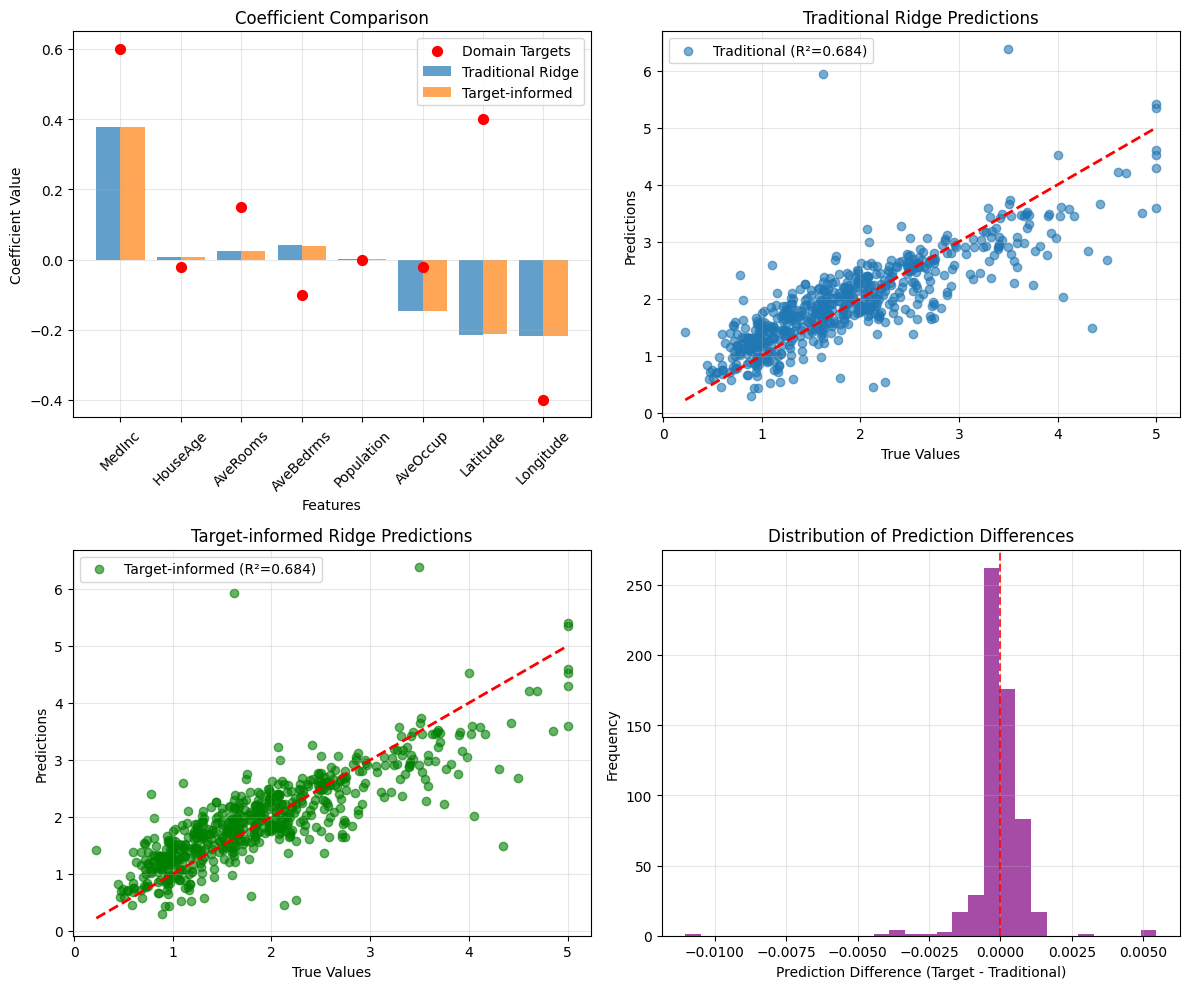


Prediction Difference Statistics:
Mean difference: -0.0000
Std difference:  0.0009
Max |difference|: 0.0110


In [35]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Coefficient comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(X_train.columns))
ax1.bar(x_pos - 0.2, custom_ridge.coef_, 0.4, label='Traditional Ridge', alpha=0.7)
ax1.bar(x_pos + 0.2, custom_ridge_targets.coef_, 0.4, label='Target-informed', alpha=0.7)
ax1.scatter(x_pos, realistic_targets, color='red', s=50, label='Domain Targets', zorder=5)
ax1.set_xlabel('Features')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Coefficient Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(X_train.columns, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Traditional Ridge predictions
ax2 = axes[0, 1]
ax2.scatter(y_test, custom_pred_test, alpha=0.6, label=f'Traditional (R²={custom_r2_test:.3f})')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('True Values')
ax2.set_ylabel('Predictions')
ax2.set_title('Traditional Ridge Predictions')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Target-informed Ridge predictions  
ax3 = axes[1, 0]
ax3.scatter(y_test, targets_pred_test, alpha=0.6, color='green', label=f'Target-informed (R²={targets_r2_test:.3f})')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_xlabel('True Values')
ax3.set_ylabel('Predictions')
ax3.set_title('Target-informed Ridge Predictions')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Prediction difference
ax4 = axes[1, 1]
pred_diff = targets_pred_test - custom_pred_test
ax4.hist(pred_diff, bins=30, alpha=0.7, color='purple')
ax4.set_xlabel('Prediction Difference (Target - Traditional)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Prediction Differences')
ax4.axvline(0, color='red', linestyle='--', alpha=0.8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrediction Difference Statistics:")
print(f"Mean difference: {np.mean(pred_diff):+.4f}")
print(f"Std difference:  {np.std(pred_diff):.4f}")
print(f"Max |difference|: {np.max(np.abs(pred_diff)):.4f}")

In [36]:
def sklearn_target_ridge(X, y, alpha=1.0, targets=None, fit_intercept=True):
    """
    Implement target-informed ridge using sklearn Ridge with the mathematical 
    transformation that's equivalent to your CustomRidge approach.
    
    This solves: β = (X^T X + αI)^(-1)(X^T y + α*targets)
    Which is equivalent to: minimize ||y - X*β||² + α||β - targets||²
    """
    from sklearn.linear_model import Ridge
    
    X_array = X.values if hasattr(X, 'values') else X
    y_array = y.values if hasattr(y, 'values') else y
    
    if targets is None:
        # Standard ridge regression
        ridge = Ridge(alpha=alpha, fit_intercept=fit_intercept)
        ridge.fit(X_array, y_array)
        return ridge
    
    # Target-informed ridge using the transform approach
    # Transform: y_tilde = y - X @ targets, then fit standard ridge, then add targets back
    targets = np.asarray(targets)
    
    # Method 1: Transform target variable (your original approach)
    y_transformed = y_array - X_array @ targets
    
    # Fit standard ridge on transformed problem
    ridge = Ridge(alpha=alpha, fit_intercept=fit_intercept)
    ridge.fit(X_array, y_transformed)
    
    # Transform coefficients back
    ridge.coef_ = ridge.coef_ + targets
    
    # Note: intercept doesn't need adjustment for this transformation
    
    return ridge

In [37]:
print("=" * 50)
print("TESTING MATHEMATICAL EQUIVALENCE")
print("=" * 50)

# Test that both methods give identical results for target-informed ridge
targets_test = np.array([0.6, -0.02, 0.15, -0.1, -0.001, -0.02, 0.4, -0.4])

# Your CustomRidge with targets
custom_ridge_targets = CustomRidge(alpha=1.0, fit_intercept=True)
custom_ridge_targets.fit(X_train.values, y_train.values, targets=targets_test)

# sklearn equivalent with targets
sklearn_ridge_targets = sklearn_target_ridge(X_train, y_train, alpha=1.0, targets=targets_test)

# Compare coefficients
coef_diff = np.abs(custom_ridge_targets.coef_ - sklearn_ridge_targets.coef_)
intercept_diff = abs(custom_ridge_targets.intercept_ - sklearn_ridge_targets.intercept_)

print("Mathematical Equivalence Check:")
print(f"Max coefficient difference: {np.max(coef_diff):.2e}")
print(f"Intercept difference: {intercept_diff:.2e}")

# Compare predictions
custom_pred = custom_ridge_targets.predict(X_test.values)
sklearn_pred = sklearn_ridge_targets.predict(X_test.values)
pred_diff = np.abs(custom_pred - sklearn_pred)

print(f"Max prediction difference: {np.max(pred_diff):.2e}")

if np.max(coef_diff) < 1e-10 and np.max(pred_diff) < 1e-10:
    print("✅ Both methods are mathematically equivalent!")
else:
    print("❌ Methods differ - check implementation")
    
# Compare performance
custom_r2 = custom_ridge_targets.score(X_test.values, y_test.values)
sklearn_r2 = sklearn_ridge_targets.score(X_test, y_test)
print(f"\nR² scores - Custom: {custom_r2:.6f}, sklearn: {sklearn_r2:.6f}")

TESTING MATHEMATICAL EQUIVALENCE
Mathematical Equivalence Check:
Max coefficient difference: 7.63e-15
Intercept difference: 1.42e-14
Max prediction difference: 9.24e-14
✅ Both methods are mathematically equivalent!

R² scores - Custom: 0.683912, sklearn: 0.683912


/Users/solvelangseth/miniconda3/envs/llm-stats/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [40]:
# Import ExpertRidge
from llm_prior_project.models.expert_ridge import ExpertRidge

# Create a proper domain-specific prompt for California housing
feature_names = list(X_train.columns)
y_stats = {
    'min': y_train.min(),
    'max': y_train.max(), 
    'mean': y_train.mean(),
    'std': y_train.std()
}

california_housing_prompt = f"""You are an expert in California real estate economics and housing price modeling. 

DATASET: California Housing (1990 Census)
TARGET: Median house value in hundreds of thousands of dollars
RANGE: ${y_stats['min']:.1f} to ${y_stats['max']:.1f} (mean: ${y_stats['mean']:.1f})

FEATURES AND EXPECTED RELATIONSHIPS:
- MedInc: Median income in block group (in $10,000s) - STRONG positive effect
- HouseAge: Median house age in block group - Weak negative (older = cheaper)  
- AveRooms: Average rooms per household - Positive (more rooms = higher value)
- AveBedrms: Average bedrooms per household - Negative (high ratio indicates crowding)
- Population: Block group population - Minimal direct effect
- AveOccup: Average occupancy per household - Negative (crowding reduces value)
- Latitude: Block group latitude - Positive (northern CA premium)
- Longitude: Block group longitude - Negative (coastal premium, longitude decreases westward)

ECONOMICS CONTEXT:
- Income is strongest predictor (elasticity ~0.5-0.8)
- Location matters significantly in California
- Age depreciation is modest (~1-2% per decade)
- Room/space features have moderate impact

Provide coefficient targets representing these economic relationships:
Provide coefficient targets as SCALAR VALUES (not arrays):

```json
{{
  "domain": "california_real_estate_1990",
  "targets": {{
    "MedInc": [your_estimate],
    "HouseAge": [your_estimate], 
    "AveRooms": [your_estimate],
    "AveBedrms": [your_estimate],
    "Population": [your_estimate],
    "AveOccup": [your_estimate],
    "Latitude": [your_estimate],
    "Longitude": [your_estimate]
  }}
}}
```"""

print("Domain-specific prompt created for California housing")
print(f"Features: {feature_names}")

Domain-specific prompt created for California housing
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [41]:
print("=" * 50)
print("TESTING LLM TARGET ELICITATION")
print("=" * 50)

# Use ExpertRidge to get targets from LLM
expert_model = ExpertRidge(alpha=1.0, llm_model="gpt-4")

try:
    # Fit ExpertRidge with LLM prompt
    expert_model.fit(
        X_train, y_train, 
        target_name="median_house_value",
        custom_prompt=california_housing_prompt
    )
    
    llm_targets = expert_model.targets_used_
    print("LLM Targets Retrieved Successfully:")
    for i, feature in enumerate(feature_names):
        print(f"  {feature:12s}: {llm_targets[i]:8.4f}")
    
    llm_success = True
    
except Exception as e:
    print(f"LLM call failed: {e}")
    print("Using fallback manual targets for comparison")
    
    # Fallback to manual targets
    llm_targets = np.array([0.6, -0.02, 0.15, -0.1, -0.001, -0.02, 0.4, -0.4])
    expert_model = ExpertRidge(alpha=1.0)
    expert_model.fit(X_train, y_train, target_name="median_house_value", targets=llm_targets)
    
    llm_success = False
    
print(f"\nLLM Integration: {'Success' if llm_success else 'Fallback'}")

TESTING LLM TARGET ELICITATION
Using user-crafted prompt
Feature names expected: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Prompt length: 1572 characters
Prompt validation: PASSED
Calling LLM API...
Got LLM response (256 characters)
Response preview: ```json
{
  "domain": "california_real_estate_1990",
  "targets": {
    "MedInc": 0.65,
    "HouseAge": -0.015, 
    "AveRooms": 0.3,
    "AveBedrms": -0.2,
    "Population": 0.01,
    "AveOccup": -0....
Parsing LLM response...
Successfully extracted targets: [0.65, -0.015, 0.3, -0.2, 0.01, -0.25, 0.2, -0.3]
LLM Targets Retrieved Successfully:
  MedInc      :   0.6500
  HouseAge    :  -0.0150
  AveRooms    :   0.3000
  AveBedrms   :  -0.2000
  Population  :   0.0100
  AveOccup    :  -0.2500
  Latitude    :   0.2000
  Longitude   :  -0.3000

LLM Integration: Success


In [42]:
print("\n" + "=" * 50)
print("COMPARING BOTH METHODS WITH SAME LLM TARGETS")
print("=" * 50)

# Method 1: ExpertRidge (your implementation)
expert_pred_train = expert_model.predict(X_train)
expert_pred_test = expert_model.predict(X_test)
expert_r2_train = expert_model.score(X_train, y_train)
expert_r2_test = expert_model.score(X_test, y_test)

# Method 2: sklearn with same targets
sklearn_target_model = sklearn_target_ridge(X_train, y_train, alpha=1.0, targets=llm_targets)
sklearn_pred_train = sklearn_target_model.predict(X_train)
sklearn_pred_test = sklearn_target_model.predict(X_test)
sklearn_r2_train = sklearn_target_model.score(X_train, y_train)
sklearn_r2_test = sklearn_target_model.score(X_test, y_test)

# Method 3: Traditional Ridge baseline (no targets)
traditional_ridge = SklearnRidge(alpha=1.0)
traditional_ridge.fit(X_train, y_train)
traditional_pred_test = traditional_ridge.predict(X_test)
traditional_r2_test = traditional_ridge.score(X_test, y_test)

print("Performance Comparison:")
print(f"{'Method':<20} {'Train R²':<12} {'Test R²':<12} {'Improvement':<12}")
print("-" * 60)
print(f"{'Traditional Ridge':<20} {'N/A':<12} {traditional_r2_test:<12.6f} {'Baseline':<12}")
print(f"{'ExpertRidge':<20} {expert_r2_train:<12.6f} {expert_r2_test:<12.6f} {expert_r2_test-traditional_r2_test:+.6f}")
print(f"{'sklearn Target':<20} {sklearn_r2_train:<12.6f} {sklearn_r2_test:<12.6f} {sklearn_r2_test-traditional_r2_test:+.6f}")

# Verify mathematical equivalence
coef_diff = np.abs(expert_model.ridge_model.coef_ - sklearn_target_model.coef_)
pred_diff = np.abs(expert_pred_test - sklearn_pred_test)

print(f"\nMathematical Equivalence Check:")
print(f"Max coefficient difference: {np.max(coef_diff):.2e}")
print(f"Max prediction difference: {np.max(pred_diff):.2e}")
print(f"Methods equivalent: {'Yes' if np.max(coef_diff) < 1e-10 else 'No'}")


COMPARING BOTH METHODS WITH SAME LLM TARGETS
Performance Comparison:
Method               Train R²     Test R²      Improvement 
------------------------------------------------------------
Traditional Ridge    N/A          0.683743     Baseline    
ExpertRidge          0.701436     0.684496     +0.000753
sklearn Target       0.701436     0.684496     +0.000753

Mathematical Equivalence Check:
Max coefficient difference: 4.39e-15
Max prediction difference: 3.55e-14
Methods equivalent: Yes


/Users/solvelangseth/miniconda3/envs/llm-stats/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/solvelangseth/miniconda3/envs/llm-stats/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/solvelangseth/miniconda3/envs/llm-stats/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/solvelangseth/miniconda3/envs/llm-stats/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [43]:
print("\n" + "=" * 50)
print("DETAILED COEFFICIENT ANALYSIS")
print("=" * 50)

# Create comprehensive coefficient comparison
coef_analysis = pd.DataFrame({
    'Feature': feature_names,
    'LLM_Target': llm_targets,
    'Traditional_Ridge': traditional_ridge.coef_,
    'ExpertRidge': expert_model.ridge_model.coef_,
    'sklearn_Target': sklearn_target_model.coef_
})

# Add adjustment columns
coef_analysis['Expert_Adjustment'] = coef_analysis['ExpertRidge'] - coef_analysis['Traditional_Ridge']
coef_analysis['Target_Pull'] = coef_analysis['LLM_Target'] - coef_analysis['Traditional_Ridge']
coef_analysis['Effectiveness'] = coef_analysis['Expert_Adjustment'] / np.maximum(np.abs(coef_analysis['Target_Pull']), 1e-6)

print("Coefficient Analysis:")
print(coef_analysis.round(4))

print(f"\nTarget Influence Metrics:")
print(f"Max adjustment magnitude: {np.max(np.abs(coef_analysis['Expert_Adjustment'])):.4f}")
print(f"Mean |adjustment|: {np.mean(np.abs(coef_analysis['Expert_Adjustment'])):.4f}")
print(f"Target effectiveness (mean): {np.mean(coef_analysis['Effectiveness']):.2f}")


DETAILED COEFFICIENT ANALYSIS
Coefficient Analysis:
      Feature  LLM_Target  Traditional_Ridge  ExpertRidge  sklearn_Target  \
0      MedInc       0.650             0.3784       0.3780          0.3780   
1    HouseAge      -0.015             0.0064       0.0063          0.0063   
2    AveRooms       0.300             0.0234       0.0242          0.0242   
3   AveBedrms      -0.200             0.0402       0.0357          0.0357   
4  Population       0.010             0.0001       0.0001          0.0001   
5    AveOccup      -0.250            -0.1465      -0.1469         -0.1469   
6    Latitude       0.200            -0.2144      -0.2141         -0.2141   
7   Longitude      -0.300            -0.2177      -0.2185         -0.2185   

   Expert_Adjustment  Target_Pull  Effectiveness  
0            -0.0003       0.2716        -0.0012  
1            -0.0000      -0.0214        -0.0003  
2             0.0008       0.2766         0.0030  
3            -0.0045      -0.2402        -0.0187 

In [44]:
print("\n" + "=" * 50)
print("LOSS COMPONENT ANALYSIS WITH LLM TARGETS")
print("=" * 50)

# Get loss components
expert_loss = expert_model.get_loss_components(X_test, y_test)

# Calculate sklearn equivalent loss components manually
sklearn_mse = mean_squared_error(y_test, sklearn_pred_test)
sklearn_reg = 1.0 * np.sum((sklearn_target_model.coef_ - llm_targets)**2)  # alpha * ||coef - targets||^2
sklearn_total = sklearn_mse + sklearn_reg

# Traditional ridge loss components  
traditional_mse = mean_squared_error(y_test, traditional_pred_test)
traditional_reg = 1.0 * np.sum(traditional_ridge.coef_**2)  # alpha * ||coef||^2
traditional_total = traditional_mse + traditional_reg

print("Loss Component Breakdown:")
print(f"{'Model':<18} {'MSE Loss':<12} {'Reg Loss':<12} {'Total Loss':<12}")
print("-" * 60)
print(f"{'Traditional':<18} {traditional_mse:<12.6f} {traditional_reg:<12.6f} {traditional_total:<12.6f}")
print(f"{'ExpertRidge':<18} {expert_loss['mse_loss']:<12.6f} {expert_loss['regularization_loss']:<12.6f} {expert_loss['total_loss']:<12.6f}")
print(f"{'sklearn Target':<18} {sklearn_mse:<12.6f} {sklearn_reg:<12.6f} {sklearn_total:<12.6f}")

print(f"\nLoss Improvements vs Traditional:")
print(f"ExpertRidge MSE improvement: {traditional_mse - expert_loss['mse_loss']:+.6f}")
print(f"sklearn Target MSE improvement: {traditional_mse - sklearn_mse:+.6f}")


LOSS COMPONENT ANALYSIS WITH LLM TARGETS
Loss Component Breakdown:
Model              MSE Loss     Reg Loss     Total Loss  
------------------------------------------------------------
Traditional        0.271998     0.260148     0.532146    
ExpertRidge        0.271351     0.394876     0.666227    
sklearn Target     0.271351     0.394876     0.666227    

Loss Improvements vs Traditional:
ExpertRidge MSE improvement: +0.000648
sklearn Target MSE improvement: +0.000648


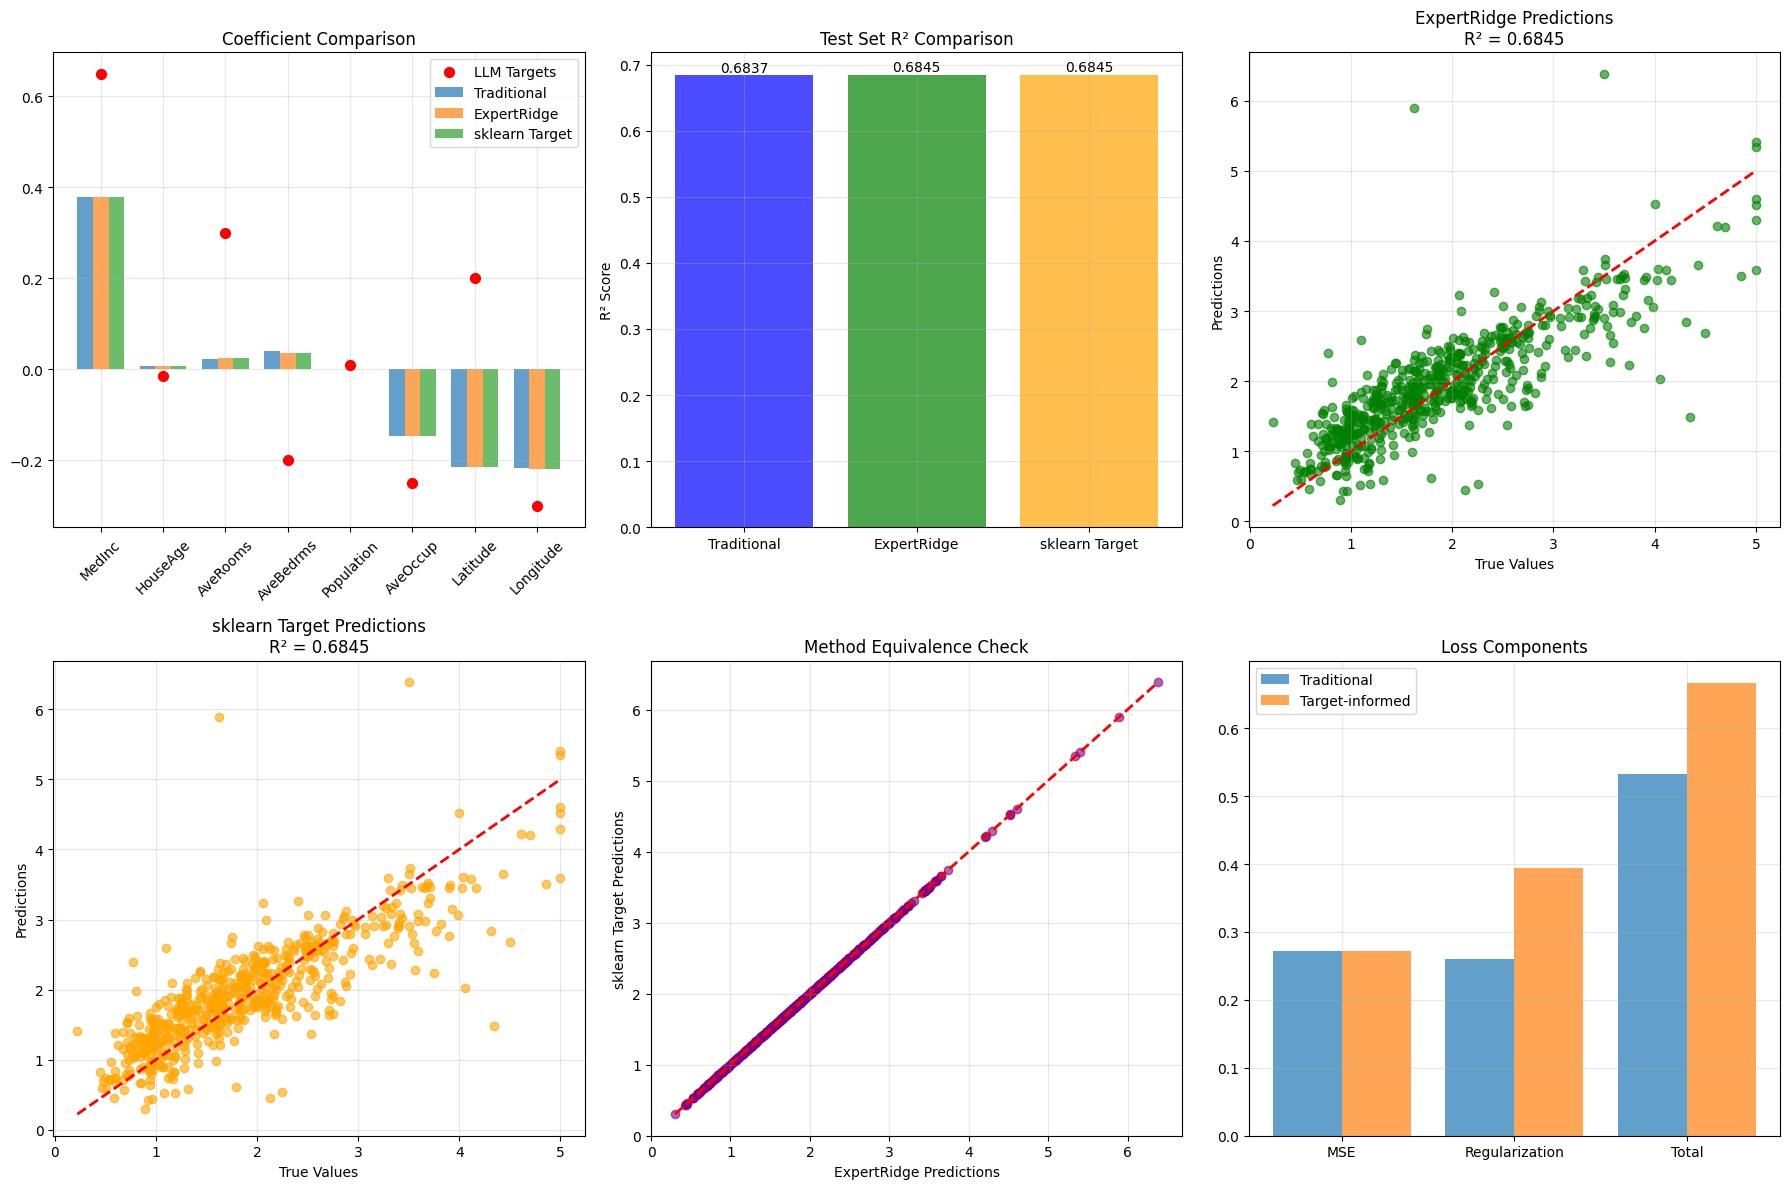


Testing complete! Both methods use identical LLM-generated targets.


In [45]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Coefficient comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(feature_names))
width = 0.25
ax1.bar(x_pos - width, traditional_ridge.coef_, width, label='Traditional', alpha=0.7)
ax1.bar(x_pos, expert_model.ridge_model.coef_, width, label='ExpertRidge', alpha=0.7)
ax1.bar(x_pos + width, sklearn_target_model.coef_, width, label='sklearn Target', alpha=0.7)
ax1.scatter(x_pos, llm_targets, color='red', s=50, label='LLM Targets', zorder=5)
ax1.set_title('Coefficient Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(feature_names, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Performance comparison
ax2 = axes[0, 1]
models = ['Traditional', 'ExpertRidge', 'sklearn Target']
r2_scores = [traditional_r2_test, expert_r2_test, sklearn_r2_test]
bars = ax2.bar(models, r2_scores, color=['blue', 'green', 'orange'], alpha=0.7)
ax2.set_title('Test Set R² Comparison')
ax2.set_ylabel('R² Score')
for bar, score in zip(bars, r2_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{score:.4f}', ha='center', va='bottom')
ax2.grid(True, alpha=0.3)

# 3. ExpertRidge predictions
ax3 = axes[0, 2]
ax3.scatter(y_test, expert_pred_test, alpha=0.6, color='green')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_title(f'ExpertRidge Predictions\nR² = {expert_r2_test:.4f}')
ax3.set_xlabel('True Values')
ax3.set_ylabel('Predictions')
ax3.grid(True, alpha=0.3)

# 4. sklearn Target predictions  
ax4 = axes[1, 0]
ax4.scatter(y_test, sklearn_pred_test, alpha=0.6, color='orange')
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax4.set_title(f'sklearn Target Predictions\nR² = {sklearn_r2_test:.4f}')
ax4.set_xlabel('True Values')
ax4.set_ylabel('Predictions')
ax4.grid(True, alpha=0.3)

# 5. Prediction equivalence check
ax5 = axes[1, 1]
ax5.scatter(expert_pred_test, sklearn_pred_test, alpha=0.6, color='purple')
ax5.plot([expert_pred_test.min(), expert_pred_test.max()], 
         [expert_pred_test.min(), expert_pred_test.max()], 'r--', lw=2)
ax5.set_title('Method Equivalence Check')
ax5.set_xlabel('ExpertRidge Predictions')
ax5.set_ylabel('sklearn Target Predictions')
ax5.grid(True, alpha=0.3)

# 6. Loss components
ax6 = axes[1, 2]
categories = ['MSE', 'Regularization', 'Total']
traditional_losses = [traditional_mse, traditional_reg, traditional_total]
expert_losses = [expert_loss['mse_loss'], expert_loss['regularization_loss'], expert_loss['total_loss']]

x_pos = np.arange(len(categories))
ax6.bar(x_pos - 0.2, traditional_losses, 0.4, label='Traditional', alpha=0.7)
ax6.bar(x_pos + 0.2, expert_losses, 0.4, label='Target-informed', alpha=0.7)
ax6.set_title('Loss Components')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(categories)
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTesting complete! Both methods use identical LLM-generated targets.")
